# Inverse Theory Assignment 3
*By Ryan Cox*

## General Functions

In [7]:
using SparseArrays
using Distributions
using LinearAlgebra
using Plots
using LaTeXStrings
using Krylov


"""
Generate some synthetic data by applying gaussian noise to model

Parameters
    G::Matrix - Model kernel
    m::Vector - True parameters
    mean::Number - Mean of gaussian noise
    std::Number - Standard deviation of gaussian noise
"""
function FakeNormalData(G::Union{Matrix, SparseMatrixCSC}, m::Vector, mean::Number, std::Number)::Vector
    N = size(G)[1] # get num. of data elements
    gaussian = Normal(mean, std)
    n = rand(gaussian, N) # N gaussian random numbers
    d = G * m + n
end


"""
An approximate measure of how well parameters, m, fit linear equality constraints defined by H*m=h.
Error is calculated as the squared Euclian length of the vector (H*m - h).
Smaller is better. For a perfect match to constraints E=0.
"""
function ConstraintsError(H::Matrix, h::Vector, m::Vector)::Float64
    Hm = H*m
    diff = Hm - h
    transpose(diff) * diff
end


"""
An approximate measure of how well modelled data, dPre, fits observed data, dObs.
Error is calculated as the squared Euclian length of the vector (dPre - Obs).
Smaller is better. For a perfect match to constraints E=0.
"""
function FitError(dObs::Vector, dPre::Vector)::Float64
    diff = dPre - dObs
    transpose(diff) * diff
end;

## Q1 | Problem 5.3

Unconstrained Results
Parameters: [1.0161112948164388, 0.36094261801189176, 0.603340606866289, -0.06932396335305047]
Parameters error (w.r.t constraints): 4.505987620724335
Data error (w.r.t true data): 0.5770888946030305
m1:m2: 2.815160205833498:1
m2:m3: 0.5982402210363459:1
m3:m4: -8.703204169006014:1
---------------------------------------
Constrained Results
Parameters: [1.0125955622833853, 0.5062977811416928, 0.25314889057084633, 0.12657444528542314]
Parameters error (w.r.t constraints): 9.860761315262648e-32
Data error (w.r.t true data): 0.5821636261026816
m1:m2: 1.9999999999999996:1
m2:m3: 2.0000000000000004:1
m3:m4: 2.0000000000000004:1


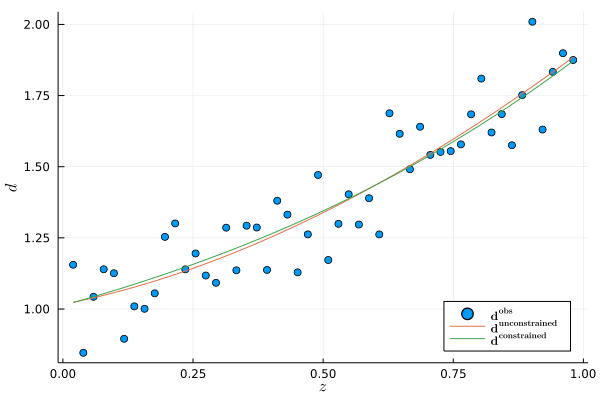

In [8]:
"""
Fit data with least squares method accounting for linear equality constraints given by H*m=h.
This is done by using Eq 3.63 from Menke.

Parameters
    G::Matrix - Model kernel
    H::Matrix - Matrix encoding of linear relationships between model parameters such that Hm=h
    h::Vector - Vector encoding desired results of linear relationships given in H
    d::Vector - Observed data
"""
function ConstrainedLeastSqFit(G::Matrix, H::Matrix, h::Vector, d::Vector)::Vector
    zero = zeros((size(H)[1],size(H)[1])) # create a zero matrix to fill corner of lMatrix
    # Creates matrices from Eq 3.63 so that we can solve for central matrix
    lMatrix = [transpose(G)*G transpose(H); H zero]
    rMatrix = vcat(transpose(G)*d, h)
    params = inv(lMatrix)*rMatrix
    params[1:size(G)[2]] # Strips 'parameters' added only to fit with constraints (labelled λ in textbook)
end


"""
Performs unconstrained least squares fitting on data D given model kernel G.
"""
function UnconstrainedLeastSqFit(G::Matrix, d::Vector)::Vector
    Gt = transpose(G)
    Gg = inv(Gt*G)*Gt
    Gg * d
end


N = 50 # number of data points
z = Vector(LinRange(0, 1, N+2)) # linear spacing, start=0, stop=1, # of values=N
z = z[2:end-1] # we are told 0 < z < 1 so this is an easy way to drop those values from z
# create true m based on 1=m[1]=2*m[2]=4*m[3]=8*m[4]
mTrue = [1, 1/2, 1/4, 1/8]

G = [ones(N) z z.^2 z.^3] # Kernel
dObs = FakeNormalData(G, mTrue, 0, 0.1) # Synthetic data with noise of mean=0, std=0.1

# Linear equality constraints. H*m=h
H = [1 -2  0  0;
     1  0 -4  0;
     1  0  0 -8]
h = [0, 0, 0]

# Fitting
mUnconstrained = UnconstrainedLeastSqFit(G, dObs)
mConstrained = ConstrainedLeastSqFit(G, H, h, dObs)

# Calculate predicted data.
dUnconstrained = G * mUnconstrained
dConstrained = G * mConstrained

function printResults(d::Vector, m::Vector, H::Matrix, h::Vector, dObs::Vector)
    println("Parameters: $m")
    println("Parameters error (w.r.t constraints): $(ConstraintsError(H, h, m))")
    println("Data error (w.r.t true data): $(FitError(dObs, d))")
    println("m1:m2: $(m[1]/m[2]):1")
    println("m2:m3: $(m[2]/m[3]):1")
    println("m3:m4: $(m[3]/m[4]):1")
end

println("Unconstrained Results")
printResults(dUnconstrained, mUnconstrained, H, h, dObs)
println("---------------------------------------")
println("Constrained Results")
printResults(dConstrained, mConstrained, H, h, dObs)

plot(z, dObs, seriestype=:scatter, label=L"\mathbf{d^{obs}}", xlabel=L"z", ylabel=L"d", legend=:bottomright) # (G) plot
plot!(z, dUnconstrained, label=L"\mathbf{d^{unconstrained}}")
plot!(z, dConstrained, label=L"\mathbf{d^{constrained}}")

We can see that while both the constrained and unconstrained parameters appear to fit the data reasonable well, the constrained fit is much closer to the parameter requirements. The unconstrained parameters typically tend to be in the right ballpark but still with orders of mangitude larger error, with respect to the parameter ratios.

Looking at the ratios themselves makes this much clearer. According to our prior information, $m_i:m_{i+1}$ should be 2:1. This isn't true in the slightest for the unconstrained solution, but is very close to exactly true for the constrained solution.

## Q2 | Problem 5.4

In [9]:
"""
Use a weighted damped least squares fit to find parameters by maximum likelihood for an exact theory.
This is based on Eq 5.17 from Menke.
The function transpose(F) * F * m = transpose(F)*f is solved for m using the conjugate gradient method from Krylov.jl

Parameters
    d::Vector - Observed data
    dCov::Matrix - Covariance matrix of data
    h::Vector - From linear equality constraints defined by H*m=h
    hCov::Matrix - Covariance matrix of H
    G::Matrix - Model Kernel
    H::Matrix - From linear equality constraints defined by H*m=h

Returns (m, stats)
    m::Vector - Estimated parameters
    stats - Information on fitting
"""
function WeightedDampedLeastSqFit(d::Vector, dCov::Union{Matrix, Diagonal}, h::Vector, hCov::Union{Matrix, Diagonal}, G::Matrix, H::Matrix)
    F = vcat(dCov^(-1/2) * G, hCov^(-1/2) * H)
    f = vcat(dCov^(-1/2) * d, hCov^(-1/2) * h)
    cgls(F, f)
end


"""
Define a custom type to store our results. Much nicer than the mess generated peturbing parameters in the last assignment.
"""
struct CubicPolynomialAnalysis
     dStd::Number
     hStd::Number
     z::Vector{Number}
     mEst::Vector{Number}
     dPre::Vector{Number}
     stats::Krylov.SimpleStats
     constraintsError::Float64
     fitError::Float64
end


"""
Solves cubic polynomial with specified scenario. Intended for Menke problems 5.3, 5.4.
Because of this limited usage I've opted for only including necessary parameters for those questions,
as opposed to great flexibility but a morass of parameters.

Parameters
     dStd::Number - Standard deviation of data
     hStd::Number - Standard deviation of prior Information
     z::Vector - Auxiliary variable d = m1 + m2*z + m3*z^2 + m4*z^4
     dObs::Vector - Observed data. Passed into this function so it is same for all perturbations. This necessitates also passing in z, G.
     G::Matrix - Model kernel
"""
function AnalyseCubicPolynomial(dStd::Number, hStd::Number, z::Vector, dObs::Vector, G::Matrix)::CubicPolynomialAnalysis
     # Linear equality constraints. H*m=h
     H = [1 -2  0  0;
          1  0 -4  0;
          1  0  0 -8]
     h = [0, 0, 0]

     # Convert standard deviations into covariance matrices, assuming no actual covariance
     dCov = Diagonal(fill(dStd^2, N))
     hCov = Diagonal(fill(hStd^2, size(h)))

     # Time to fit
     (mEst, stats) = WeightedDampedLeastSqFit(dObs, dCov, h, hCov, G, H)
     dPre = G*mEst # predict data with model

     # Calculate some interesting erros
     constraintsError = ConstraintsError(H, h, mEst)
     fitError = FitError(dObs, dPre)

     # Create the object we return
     CubicPolynomialAnalysis(dStd, hStd, z, mEst, dPre, stats, constraintsError, fitError)
end


"""
Pretty printing of our cubic polynomial analysis.
"""
function Base.show(io::IO, m::CubicPolynomialAnalysis)
     println(io, "Analysis of data with std $(m.dStd) and prior information with std $(m.hStd):")
     println(io, "      Estimated parameters: $(m.mEst)")
     println(io, "      Fit error: $(m.fitError)")
     println(io, "      Contraints error: $(m.constraintsError)")
     println(io, "      m1:m2: $(m.mEst[1]/m.mEst[2]):1")
     println(io, "      m2:m3: $(m.mEst[2]/m.mEst[3]):1")
     println(io, "      m3:m4: $(m.mEst[3]/m.mEst[4]):1")
end


"""
Recipe to plot CubicPolynomialAnalysis easily
"""
@recipe function f(o::CubicPolynomialAnalysis)
     x = o.z
     y = o.dPre
     seriestype --> :line
     label --> L"\sigma_m = %$(round(o.hStd, digits=2))"
     legend --> :bottomright
     xguide --> "z"
     yguide --> "d"
     x, y
end


"""
Run AnalyseCubicPolynomial() for a range of uncertainty in the prior information. 
"""
function PerturbedAnalysis(dStd::Number)
     # Setup data for fitting
     N = 50 # number of data points

     # Prepare auxilary variable
     z = Vector(LinRange(0, 1, N+2)) # linear spacing, start=0, stop=1, # of values=N
     z = z[2:end-1] # we are told 0 < z < 1 so this is an easy way to drop those values from z

     # Create true parameters based on 1=m[1]=2*m[2]=4*m[3]=8*m[4]
     mTrue = [1, 1/2, 1/4, 1/8]

     G = [ones(N) z z.^2 z.^3] # Kernel
     dObs = FakeNormalData(G, mTrue, 0, dStd) # Synthetic data with noise of mean=0, std=dStd

     stdRange = LinRange(0.01, 2.5, 50) # Here's the range of std we will test.
     results = AnalyseCubicPolynomial.(dStd, stdRange, Ref(z), Ref(dObs), Ref(G)) # Vectorised, runs analysis for all values in stdRange

     # Plot data, model predictions
     p = plot(z, dObs, seriestype=:scatter, label="Data")
     plotRange = 1:10:length(results) # start:step:stop - We only plot some values so as not to make the graph uselessly dense
     for i in  plotRange 
          r = results[i]
          p = plot!(r)
     end
     display(p)

     # Plot errors
     # Start by grouping values into vectors we can pass to the plotting function
     eStd = Vector{Number}(undef, length(results))
     eFitErr = Vector{Number}(undef, length(results))
     eConErr = Vector{Number}(undef, length(results))
     for i in 1:length(results)
          r = results[i]
          eStd[i] = r.hStd
          eFitErr[i] = r.fitError
          eConErr[i] = r.constraintsError
     end
     e = plot(eStd, eFitErr, label="Fit error", xguide="Standard Deviation of Prior Information", yguide="Error", legend=:bottomright)
     e = plot!(eStd, eConErr, label="Constraints error")
     display(e)

     # Output parameters
     display(results[plotRange]) #NB: Display shows our vector of results, falling back on our custom show method for each element
end;

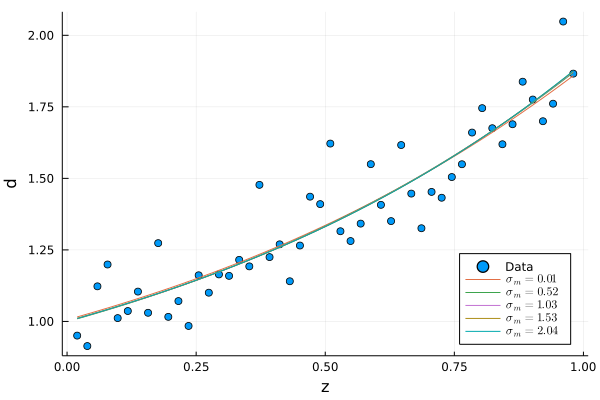

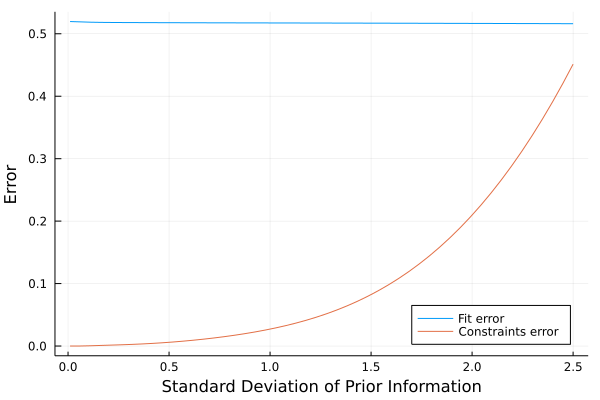

5-element Vector{CubicPolynomialAnalysis}:
 Analysis of data with std 0.1 and prior information with std 0.01:
      Estimated parameters: Number[1.00573745136012, 0.5029891395873969, 0.2514759594934739, 0.12572963619218722]
      Fit error: 0.5195253028746416
      Contraints error: 9.561030795535776e-8
      m1:m2: 1.9995212067304848:1
      m2:m3: 2.000148008583103:1
      m3:m4: 2.0001327221616547:1

 Analysis of data with std 0.1 and prior information with std 0.5181632653061224:
      Estimated parameters: Number[0.9990344423070353, 0.5050661241315, 0.26017626377943215, 0.13335498367859158]
      Fit error: 0.5176587662515967
      Contraints error: 0.00645717721621077
      m1:m2: 1.978027023738628:1
      m2:m3: 1.9412459722293363:1
      m3:m4: 1.9510051788278242:1

 Analysis of data with std 0.1 and prior information with std 1.0263265306122449:
      Estimated parameters: Number[1.0006141816126615, 0.4981090362638144, 0.2562899206101007, 0.14611526223955876]
      Fit error:

In [10]:
PerturbedAnalysis(0.1)

While individual iterations do vary, presumably due to noise in the data, there are some fairly consistant trends. The error in the fit does not append to depend much on the standard deviation of the model constraints. There does seem to be a slight decline in fit error as the standard deviation of prior information increases, but this effect is subtle. We can henceforth conclude that applying the constraints has little impact on fit accuracy.

As might be expected, the match with the parameter constraints is increaingly poor as the uncertainty in the prior information grows. All this agrees with what was observed in the previous question.

*NB: For ease of processing, I approximated an unconstrained fit by just using large $\sigma_m$*.

# Q3 | Problem 5.5

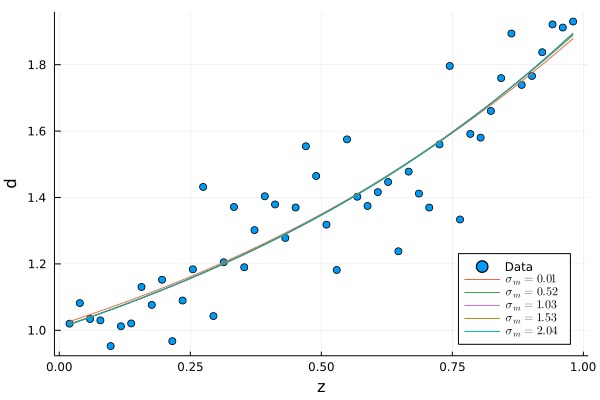

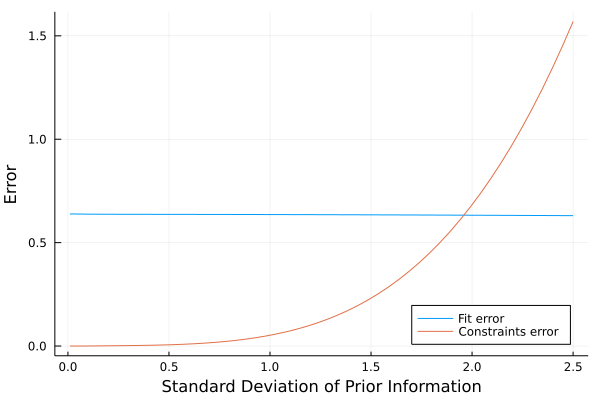

5-element Vector{CubicPolynomialAnalysis}:
 Analysis of data with std 0.1118033988749895 and prior information with std 0.01:
      Estimated parameters: Number[1.0165591900442421, 0.5083838876448425, 0.2541712209247278, 0.12708079033858624]
      Fit error: 0.6387855645812739
      Contraints error: 6.689880065438327e-8
      m1:m2: 1.9995897091734962:1
      m2:m3: 2.000163062502655:1
      m3:m4: 2.0000758592036583:1

 Analysis of data with std 0.1118033988749895 and prior information with std 0.5181632653061224:
      Estimated parameters: Number[1.0082726317144313, 0.518578221625331, 0.2547232701764094, 0.13548911447724282]
      Fit error: 0.6367403160129421
      Contraints error: 0.006668521084895212
      m1:m2: 1.9443019194949938:1
      m2:m3: 2.035849419121339:1
      m3:m4: 1.8800275664890667:1

 Analysis of data with std 0.1118033988749895 and prior information with std 1.0263265306122449:
      Estimated parameters: Number[1.0084949598108848, 0.5208849576315072, 0.236181

In [11]:
PerturbedAnalysis(( 0.1^2 + 0.05^2 )^0.5) # as data variance is effectively σ_d^2 + σ_g^2, as per assignment question

I see no discenable difference with the trends observed in the previous question. It seems probable that the small uncertainty theory is not enough to make a drastic difference to the results. Do note that the graphs cannot be directly compared because the data is necessarily different, thanks to the differing data variances. Instead I ran each one a few times to observe the trends.

I did consider printing out a few runs, but the abundance of graphs would just take up a lot of space for little benefit.

## Q4

The graphs refuse to print neatly in their sections, unfortunately. Error bars are ±σ.

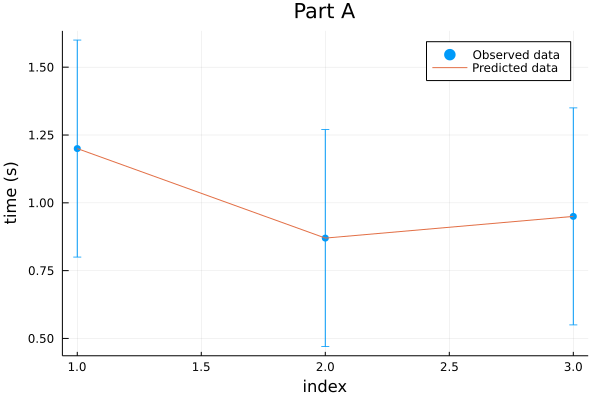

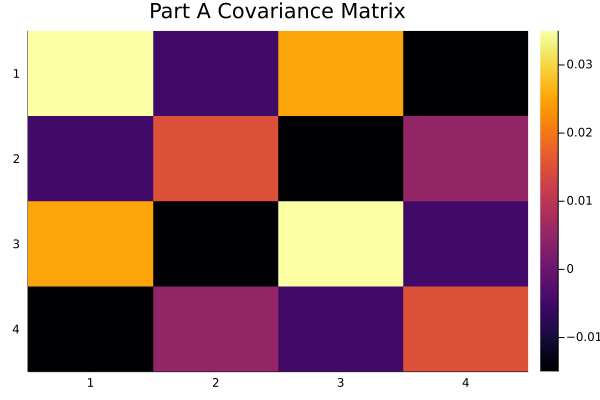


Part A
Analysis of uncorrelated data with std 0.4.
      Data: [1.2, 0.87, 0.95]
      Estimated parameters (s/km): [0.3212499999999998, 0.27875000000000005, 0.23874999999999996, 0.1962500000000001]
      Estimated velocities (km/s): [3.112840466926072, 3.58744394618834, 4.188481675392671, 5.095541401273883]
      Covariance of parameters: [0.03499999999999999 -0.004999999999999992 0.025 -0.015000000000000012; -0.004999999999999994 0.015000000000000003 -0.015000000000000005 0.0050000000000000044; 0.025 -0.015000000000000003 0.03500000000000002 -0.0050000000000000105; -0.015000000000000012 0.005000000000000004 -0.005000000000000009 0.01500000000000002]


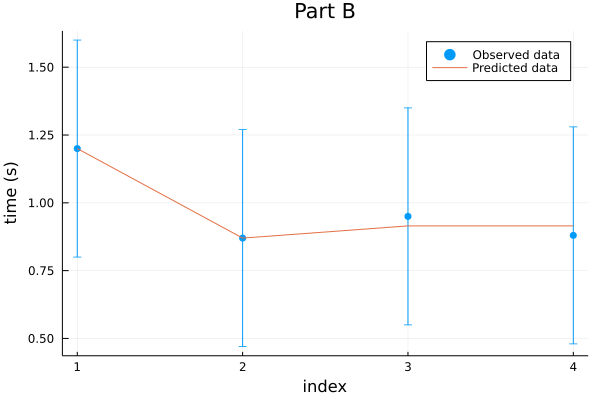

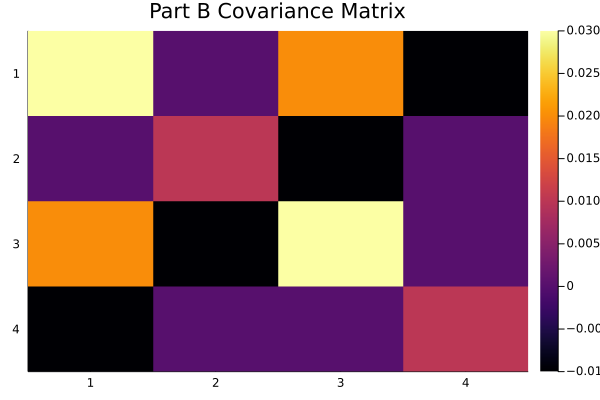

----------------------------------

Part B
Analysis of uncorrelated data with std 0.4.
      Data: [1.2, 0.87, 0.95, 0.88]
      Estimated parameters (s/km): [0.3299999999999999, 0.27000000000000013, 0.24749999999999994, 0.18749999999999997]
      Estimated velocities (km/s): [3.030303030303031, 3.703703703703702, 4.0404040404040416, 5.333333333333334]
      Covariance of parameters: [0.02999999999999999 1.3010426069826053e-17 0.01999999999999998 -0.010000000000000005; 1.3010426069826053e-17 0.010000000000000005 -0.010000000000000004 -8.239936510889834e-18; 0.01999999999999998 -0.010000000000000005 0.030000000000000013 1.3010426069826053e-17; -0.010000000000000005 -8.023096076392733e-18 1.3010426069826053e-17 0.010000000000000009]
----------------------------------


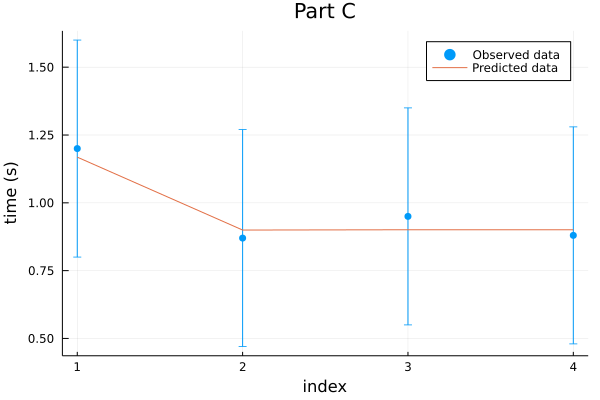

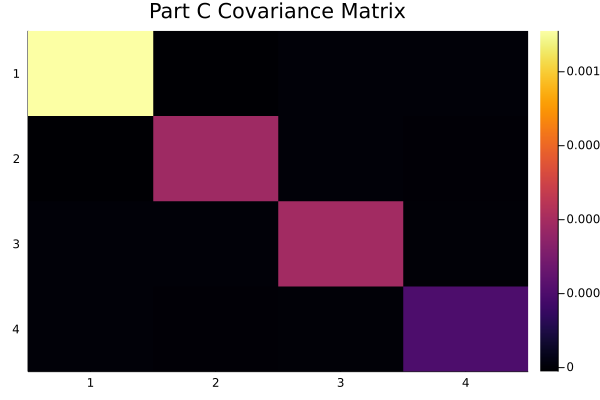


Part C
Analysis of uncorrelated data with std 0.4.
      Data: [1.2, 0.87, 0.95, 0.88]
      Prior parameters: [0.3333333333333333, 0.25, 0.25, 0.2] with std [0.03422300320267803, 0.022228492625486533, 0.022228492625486533, 0.015905414575341014]
      Estimated parameters (s/km): [0.3337968813072855, 0.2503717507463051, 0.2498170136342059, 0.19999652100044796]
      Estimated velocities (km/s): [2.9958338618491274, 3.994060819638047, 4.002929926399041, 5.000086976501757]
      Covariance of parameters: [0.0011382817716291713 -1.3562359547164167e-5 -2.0544396532842272e-9 1.6837018031875076e-7; -1.3562359547164167e-5 0.0004767521829909851 7.221889274652791e-8 -5.918649386812232e-6; -2.0544396532842272e-9 7.221889274652793e-8 0.0004881138215138534 -3.030516366326001e-6; 1.6837018031875087e-7 -5.918649386812232e-6 -3.030516366326e-6 0.0002483638719889147]

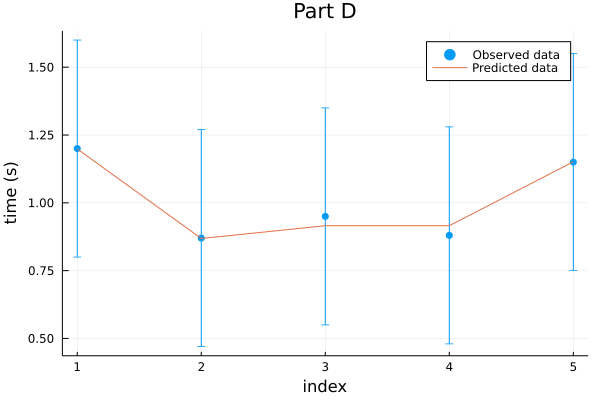

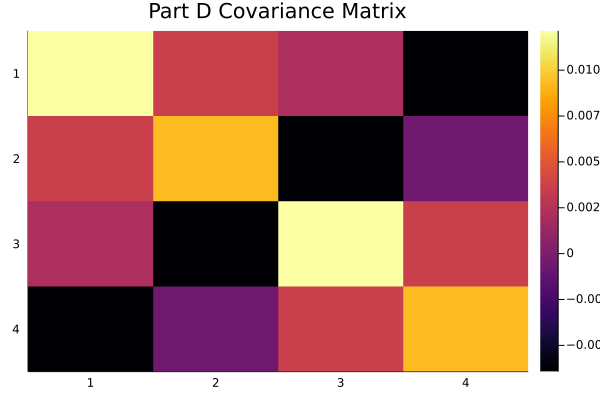


----------------------------------

Part D
Analysis of uncorrelated data with std 0.4.
      Data: [1.2, 0.87, 0.95, 0.88, 1.15]
      Estimated parameters (s/km): [0.3291071428571429, 0.27017857142857143, 0.24660714285714277, 0.18767857142857147]
      Estimated velocities (km/s): [3.0385241454150838, 3.701255783212161, 4.055032585083274, 5.328258801141769]
      Covariance of parameters: [0.012142857142857162 0.003571428571428579 0.0021428571428571356 -0.006428571428571443; 0.0035714285714285787 0.009285714285714288 -0.006428571428571428 -0.0007142857142857185; 0.0021428571428571356 -0.006428571428571428 0.012142857142857138 0.0035714285714285787; -0.006428571428571443 -0.0007142857142857185 0.0035714285714285787 0.009285714285714303]

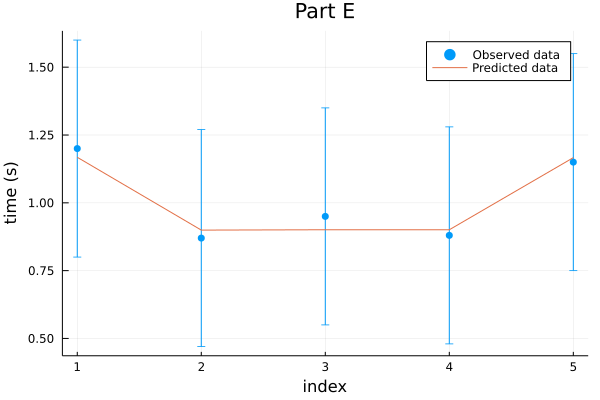

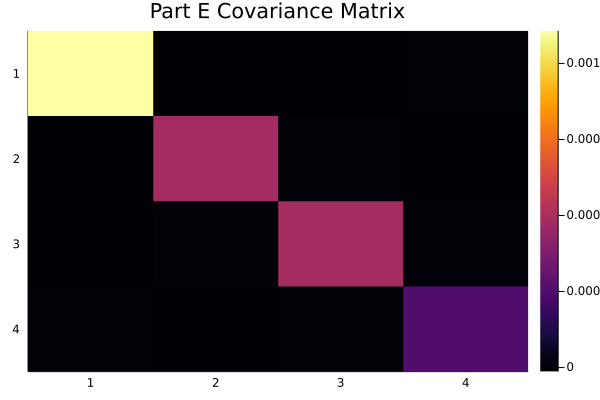


----------------------------------

Part E
Analysis of uncorrelated data with std 0.4.
      Data: [1.2, 0.87, 0.95, 0.88, 1.15]
      Prior parameters: [0.3333333333333333, 0.25, 0.25, 0.2] with std [0.03422300320267803, 0.022228492625486533, 0.022228492625486533, 0.015905414575341014]
      Estimated parameters (s/km): [0.3335613330998074, 0.25037454230834544, 0.24971600695715887, 0.1999971132743798]
      Estimated velocities (km/s): [2.997949404707477, 3.994016287680172, 4.004549056286806, 5.000072169182168]
      Covariance of parameters: [0.0011071553475418261 -1.3193469692881167e-5 -1.3349541559504547e-5 2.466359832143729e-7; -1.3193469692881167e-5 0.0004767478111516691 2.30404509085541e-7 -5.9195769415016e-6; -1.3349541559504547e-5 2.3040450908554095e-7 0.000482390214718718 -2.9969547919818783e-6; 2.466359832143731e-7 -5.919576941501602e-6 -2.9969547919818783e-6 0.0002483636751935525]
----------------------------------



In [12]:
"""
Structure for storing results of the tomography fitting.
"""
struct TomographyAnalysis
     G::Matrix
     d::Vector # Observed
     dStd::Real
     m::Vector # Estimated
     covM::Matrix
     fig::Any # plot
     label::String
end

struct TomographyAnalysisWithPrior
     G::Matrix
     d::Vector # Observed
     dStd::Real
     m::Vector # Estimated
     covM::Matrix
     priorM::Vector
     priorMStd::Vector
     fig::Any # plot
     label::String
end


"""
Solves for velocities in a tomography problem.
As t=d/v we have to use inverted (1/v) velocities in the model parameters.

Parameters
     G::Matrix - Model kernel
     dObs::Vector - Observed data
     dStd::Real - Standard deviation of data
     p::Integer - Number of singular values 

Returns as TomographyAnalysis
"""
function TomographyFit(G::Matrix, dObs::Vector, dStd::Real, label::String, p::Integer=-1)::TomographyAnalysis
     # Decompose kernel G into U, S and V such that G = U * Diagonal(S) * Vt
     decomposition = svd(G)
     U = decomposition.U
     S = decomposition.S # The book calls it L. It is provided here already as a vector of the singular values.
     V = decomposition.V
     Vt = decomposition.Vt # transpose of V

     p = p < 0 ? length(S) : p # Use length(S) for p unless p specifically set in function call
     Sp = S[1:p] # Truncate component matrices
     Up = U[:,1:p]
     Vp = V[:,1:p]

     # Estimate parameters, their covariance
     mEst = Vp * ((transpose(Up) * dObs) ./ Sp)
     covM = dStd^2 * Vp * (Diagonal(Sp)^(-2)) * transpose(Vp)

     # prepare plots
     fig = plot(dObs, seriestype=:scatter, yerror=dStd, markerstrokecolor=:auto, label="Observed data", xlabel="index", ylabel="time (s)", title=label)
     fig = plot!(G * mEst, label="Predicted data")

     TomographyAnalysis(G, dObs, dStd, mEst, covM, fig, label)
end

"""
Fit a linear, explicit least-squares tomogaphy problem with Gaussian variances.
Uses approach from Menke section 5.2.6 with cov(g)=0, and uncorrelated data and parameters.

Parameters
     G::Matrix - Kernel of model
     dObs::Matrix - Observed data
     dStd::Real - Standard deviation of uncorrelated observed data
     vMean::Vector - Velocity values from prior information
     vStd::Real - Standard deviation of velocity values.
     label::String - Label used in output

Returns as TomographyAnalysisWithPrior
"""
function TomographyFitWithPriorInfo(G::Matrix, dObs::Vector, dStd::Real, vMean::Vector, vStd::Real, label::String)::TomographyAnalysisWithPrior
     mMean = 1 ./ vMean # invert velocities to get parameters
     mPriorStd = mMean .* (vStd ./ vMean).^0.5 # find std accordingly

     # prep values needed for next steps
     covD = dStd^2 * I
     covMPrior = diagm(mPriorStd.^2)
     Gg = covMPrior * transpose(G) * inv(covD + (G * covMPrior * transpose(G)))
     R = Gg * G

     # estimate parameters, their covariance
     mEst = mMean + Gg * (dObs - G*mMean)
     covMEst = Gg * covD * transpose(Gg) + (I - R) * covMPrior * transpose(I - R)

     # prepare plots
     fig = plot(dObs, seriestype=:scatter, yerror=dStd, markerstrokecolor=:auto, label="Observed data", xlabel="index", ylabel="time (s)", title=label)
     fig = plot!(G * mEst, label="Predicted data")

     TomographyAnalysisWithPrior(G, dObs, dStd, mEst, covMEst, mMean, mPriorStd, fig, label)
end


"""
Pretty printing of our tomography analysis.
"""
function Base.show(io::IO, m::TomographyAnalysis)
     println(m.label)
     println(io, "Analysis of uncorrelated data with std $(m.dStd).")
     println(io, "      Data: $(m.d)")
     println(io, "      Estimated parameters (s/km): $(m.m)")
     println(io, "      Estimated velocities (km/s): $(1 ./ m.m)")
     println(io, "      Covariance of parameters: $(m.covM)")
     display(m.fig)
     display(heatmap(m.covM, title="$(m.label) Covariance Matrix", yflip=true))
     println("----------------------------------\n")
     
end


function Base.show(io::IO, m::TomographyAnalysisWithPrior)
     println(m.label)
     println(io, "Analysis of uncorrelated data with std $(m.dStd).")
     println(io, "      Data: $(m.d)")
     println(io, "      Prior parameters: $(m.priorM) with std $(m.priorMStd)")

     println(io, "      Estimated parameters (s/km): $(m.m)")
     println(io, "      Estimated velocities (km/s): $(1 ./ m.m)")
     println(io, "      Covariance of parameters: $(m.covM)")
     display(m.fig)
     display(heatmap(m.covM, title="$(m.label) Covariance Matrix", yflip=true))
     println("----------------------------------\n")
end


println("The graphs refuse to print neatly in their sections, unfortunately. Error bars are ±σ.")

# Part A
Ga = 2 * [1 1 0 0;
          0 0 1 1;
          0 1 0 1] # Kernel. Note the cofficent of 2 for the 2km block dimensions.
da = [1.20, 0.87, 0.95] # Observed data, in seconds, for Q4a.
show(TomographyFit(Ga, da, sqrt(0.16), "Part A"))


# Part B
Gb = 2 * [1 1 0 0;
          0 0 1 1;
          0 1 0 1;
          0 1 0 1]
db = [1.20, 0.87, 0.95, 0.88]
show(TomographyFit(Gb, db, sqrt(0.16), "Part B", 3,)) # using p=3 to keep error reasonable

# Part C
vc = [3.0, 4.0, 4.0, 5.0] # prior velocity information
show(TomographyFitWithPriorInfo(Gb, db, sqrt(0.16), vc, sqrt(0.001), "Part C"))

# Part D
Gd = 2 * [1 1 0 0;
          0 0 1 1;
          0 1 0 1;
          0 1 0 1;
          1 0 1 0]
dd = [1.20, 0.87, 0.95, 0.88, 1.15]
show(TomographyFit(Gd, dd, sqrt(0.16), "Part D", 3))

# Part E
ve = [3.0, 4.0, 4.0, 5.0] # prior velocity information
show(TomographyFitWithPriorInfo(Gd, dd, sqrt(0.16), ve, sqrt(0.001), "Part E"))

The covariance matrices are all symmetrical about the diagonal, as we'd hope. While in truth our parameters are uncorrelated, this is not reflected entirely in our covariance matrices, due to the links in the data used to determine them.

In Part A we see that there are seperate covariances for the pairs (1,2), (3,4) and (2,4). This matches up nicely with the squares passed through by our measured rays. We have no measurement for (1,3) so I'd suspect the covariance values there are largely meaningless. There are negative values for all the covariances where a ray would have had to have travelled diagonally, which our model is incapable of handling.

In Part B we see similar behaviour. Note that (1,2), (2,4) and (3,4) all have very similar covariances which are all extremely close to zero. This approximately indicates the uncorrelated nature of these parameter. The other values are of little use, given we have no data for their combinations.

In Part C this uncorrelated state becomes much more apparent.

The structure of covariance matrix for Part D is much like in Part A, except the addition of the last measurement makes (1,3) more meaningful. While in Part A it was large, in Part D it is closer to the covariance associated with the other pairs, which are all around zero as for their uncorrelated true nature.

In Part E it is very like part C. This seems to indicate that the constraints also greatly constrain the covariant matrix for the estimated parameters.